# Train and test datasets

Now that we've decided we're going to use a machine learning approach, we need to come up with train and test datasets on which we can build, and then evaluate a model.

### Positive examples

The tricky thing when working with graph data is that we can't just randomly split the data, as this could lead to data leakage.

Data leakage can occur when data outside of your training data is inadvertently used to create your model. This can easily happen when working with graphs because pairs of nodes in our training set may be connected to those in the test set.

When we compute link prediction measures over that training set the __measures computed contain information from the test set__ that we’ll later evaluate our model against.

Instead we need to split our graph into training and test sub graphs. If our graph has a concept of time our life is easy — we can split the graph at a point in time and the training set will be from before the time, the test set after.

This is still not a perfect solution and we’ll need to try and ensure that the general network structure in the training and test sub graphs is similar.

Once we’ve done that we’ll have pairs of nodes in our train and test set that have relationships between them. They will be the __positive examples__ in our machine learning model.

We are lucky that our citation graph contains a times. We can create train and test graphs by splitting the data on a particular year. Now we need to figure out what year that should be. Let's have a look at the distribution of the first year that co-authors collaborated:

In [1]:
from neo4j import GraphDatabase

# tag::imports[]
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# end::imports[]

In [3]:
#bolt_uri = "bolt://link-prediction-neo4j"
bolt_uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(bolt_uri, auth=("neo4j", "letmein"))

print(driver.address)

localhost:7687


We can create the co-author graph by running the query below to do this:

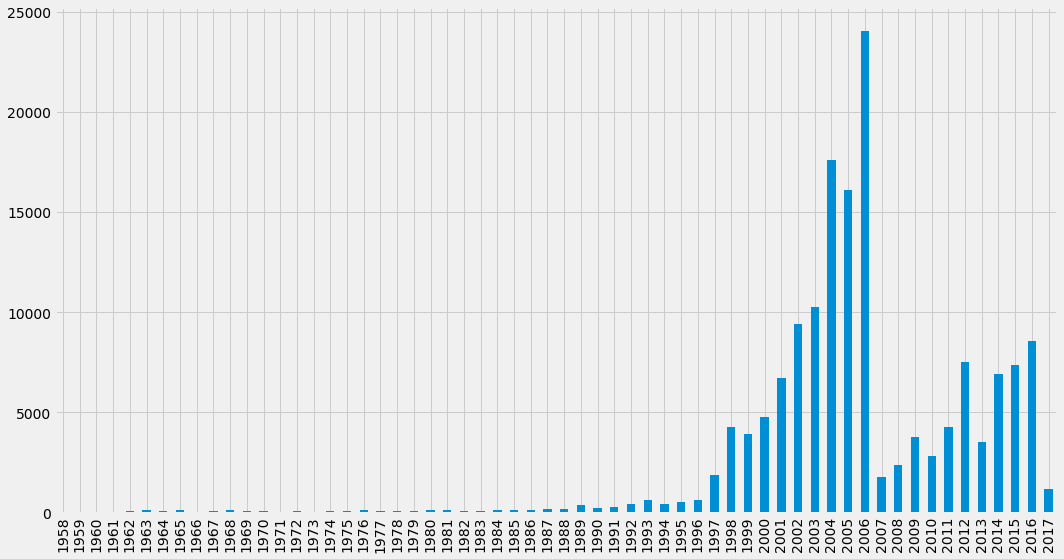

In [8]:
# tag::determine-split[]
query = """
MATCH p=()-[r:CO_AUTHOR]->()
WITH r.year AS year, count(*) AS count
ORDER BY year
RETURN toString(year) AS year, count
"""

with driver.session(database="neo4j") as session:
    result = session.run(query)
    by_year = pd.DataFrame([dict(record) for record in result])

ax = by_year.plot(kind='bar', x='year', y='count', legend=None, figsize=(15,8))
ax.xaxis.set_label_text("")
plt.tight_layout()

plt.show()
# end::determine-split[]

It looks like 2006 would act as a good year on which to split the data. We'll take all the co-authorships from 2005 and earlier as our train graph, and everything from 2006 onwards as the test graph.

Let's create explicit `CO_AUTHOR_EARLY` and `CO_AUTHOR_LATE` relationships in our graph based on that year. The following code will create these relationships for us:

In [9]:
# tag::sub-graphs[]
query = """
MATCH (a)-[r:CO_AUTHOR]->(b)
where r.year < 2006
MERGE (a)-[:CO_AUTHOR_EARLY {year: r.year}]-(b);
"""

with driver.session(database="neo4j") as session:
    display(session.run(query).consume().counters)

query = """
MATCH (a)-[r:CO_AUTHOR]->(b)
where r.year >= 2006
MERGE (a)-[:CO_AUTHOR_LATE {year: r.year}]-(b);
"""

with driver.session(database="neo4j") as session:
    display(session.run(query).consume().counters)
# end::sub-graphs[]

{'relationships_created': 81096, 'properties_set': 81096}

{'relationships_created': 74128, 'properties_set': 74128}

Let's quickly check how many co-author relationship we have in each of these sub graphs:

In [10]:
query = """
MATCH ()-[:CO_AUTHOR_EARLY]->()
RETURN count(*) AS count
"""

with driver.session(database="neo4j") as session:
    result = session.run(query)
    df = pd.DataFrame([dict(record) for record in result])
df

,count
0,81096


In [11]:
query = """
MATCH ()-[:CO_AUTHOR_LATE]->()
RETURN count(*) AS count
"""

with driver.session(database="neo4j") as session:
    result = session.run(query)
    df = pd.DataFrame([dict(record) for record in result])
df

,count
0,74128


We have a split of 52-48, which is a bit on the high side, but should be ok. Now for the __negative examples__.

### Negative examples

The simplest approach would be to use all pair of nodes that don’t have a relationship. __The problem with this approach is that there are significantly more examples of pairs of nodes that don’t have a relationship than there are pairs of nodes that do__.

The maximum number of negative examples is equal to:

```
# negative examples = (# nodes)² - (# relationships) - (# nodes)
```

i.e. the number of nodes squared, minus the relationships that the graph has, minus self relationships.

If we use all of these negative examples in our training set we will have a massive class imbalance — there are many negative examples and relatively few positive ones.

A model trained using data that’s this imbalanced will achieve very high accuracy by __predicting that any pair of nodes don’t have a relationship__ between them, which is not quite what we want!

So we need to try and reduce the number of negative examples. An approach described in several link prediction papers is to use pairs of nodes that are a __specific number of hops away from each other__.

This will significantly reduce the number of negative examples, although there will still be a lot more negative examples than positive.

To solve this problem we either need to down sample the negative examples or up sample the positive examples.

We're going to take the down sampling approach in this guide, and the following function will do this for us:

In [18]:
# tag::positive-negative-examples[]
with driver.session(database="neo4j") as session:
    result = session.run("""
             MATCH (author:Author)-[:CO_AUTHOR_EARLY]->(other:Author)
             RETURN id(author) AS node1, id(other) AS node2, 1 AS label""")
    train_existing_links = pd.DataFrame([dict(record) for record in result])

    result = session.run("""
             MATCH (author:Author)
             WHERE (author)-[:CO_AUTHOR_EARLY]-()
             MATCH (author)-[:CO_AUTHOR_EARLY*2..3]-(other)
             WHERE not((author)-[:CO_AUTHOR_EARLY]-(other))
             RETURN id(author) AS node1, id(other) AS node2, 0 AS label""")
    train_missing_links = pd.DataFrame([dict(record) for record in result])
    train_missing_links.count()
    train_missing_links = train_missing_links.drop_duplicates()
# end::positive-negative-examples[]

In [19]:
# tag::count-positive-negative[]
training_df = train_missing_links.append(train_existing_links, ignore_index=True)
training_df['label'] = training_df['label'].astype('category')

count_class_0, count_class_1 = training_df.label.value_counts()
print(f"Negative examples: {count_class_0}")
print(f"Positive examples: {count_class_1}")
# end::count-positive-negative[]

# tag::down-sample[]
df_class_0 = training_df[training_df['label'] == 0]
df_class_1 = training_df[training_df['label'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_train_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random downsampling:')
print(df_train_under.label.value_counts())
# end::down-sample[]

Negative examples: 973019
Positive examples: 81096
Random downsampling:
0    81096
1    81096
Name: label, dtype: int64


Let's now do the same thing for our test set:

In [20]:
# tag::test-positive-negative-examples[]
with driver.session(database="neo4j") as session:
    result = session.run("""
             MATCH (author:Author)-[:CO_AUTHOR_LATE]->(other:Author)
             RETURN id(author) AS node1, id(other) AS node2, 1 AS label""")
    test_existing_links = pd.DataFrame([dict(record) for record in result])

    result = session.run("""
             MATCH (author:Author)
             WHERE (author)-[:CO_AUTHOR_LATE]-()
             MATCH (author)-[:CO_AUTHOR_LATE*2..3]-(other)
             WHERE not((author)-[:CO_AUTHOR_LATE]-(other))
             RETURN id(author) AS node1, id(other) AS node2, 0 AS label""")
    test_missing_links = pd.DataFrame([dict(record) for record in result])    
    test_missing_links = test_missing_links.drop_duplicates()
# end::test-positive-negative-examples[]

In [29]:
# Compute positive and negative examples

# tag::count-test-positive-negative[]
test_df = test_missing_links.append(test_existing_links, ignore_index=True)
test_df['label'] = test_df['label'].astype('category')

count_class_0, count_class_1 = test_df.label.value_counts()
print(f"Negative examples: {count_class_0}")
print(f"Positive examples: {count_class_1}")
# end::count-test-positive-negative[]

# Down sample the negative examples

# tag::down-sample-test[]
df_class_0 = test_df[test_df['label'] == 0]
df_class_1 = test_df[test_df['label'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random downsampling:')
print(df_test_under.label.value_counts())
# end::down-sample-test[]

Negative examples: 1265118
Positive examples: 74128
Random downsampling:
0    74128
1    74128
Name: label, dtype: int64


Before we move on, let's have a look at the contents of our train and test DataFrames:

In [27]:
# tag::train-preview[]
df_train_under.sample(5, random_state=42)
# end::train-preview[]

,node1,node2,label
1008082,101053,101054,1
999032,35945,77989,1
974181,2657,2658,1
734937,166632,29136,0
348443,58706,151194,0


In [30]:
# tag::test-preview[]
df_test_under.sample(5, random_state=42)
# end::test-preview[]

,node1,node2,label
943602,200945,175275,0
1289329,96553,145288,1
1338191,107714,263014,1
1317560,135048,223250,1
1315553,117068,222134,1


In [31]:
# Save our DataFrames to CSV files for use in the next notebook

df_train_under.to_csv("data/df_train_under.csv", index=False)
df_test_under.to_csv("data/df_test_under.csv", index=False)

df_train_under = pd.read_csv("data/df_train_under.csv")
df_test_under = pd.read_csv("data/df_test_under.csv")

df_train_under.sample(5, random_state=42).to_csv("data/df_train_under_basic_sample.csv", index=False)
df_test_under.sample(5, random_state=42).to_csv("data/df_test_under_basic_sample.csv", index=False)

## Link Prediction with the Graph Data Science Library

### Train and test datasets
To avoid data leakage, we need to split our graph into training and test sub graphs. The GDS Library has a Split Relationships algorithm that takes care of this for us.

Before we use that algorithm, let’s create an in-memory graph of our co-authors, by running the following query:

In [34]:
# Create in-memory graph Cypher
query = """
CALL gds.graph.create(
  'linkpred',
  'Author',
  {
    CO_AUTHOR: {
      orientation: 'UNDIRECTED'
    }
  }
);
"""

with driver.session(database="neo4j") as session:
    display(session.run(query).consume().counters)  

{}

And now we will use the Split Relationships algorithm to create both train and test in-memory graphs:

In [36]:
# Create test graph Cypher
query = """
CALL gds.alpha.ml.splitRelationships.mutate('linkpred', {
  relationshipTypes: ['CO_AUTHOR'],
  remainingRelationshipType: 'CO_AUTHOR_REMAINING',
  holdoutRelationshipType: 'CO_AUTHOR_TESTGRAPH',
  holdoutFraction: 0.2
})
YIELD createMillis, computeMillis, mutateMillis, relationshipsWritten;
"""

with driver.session(database="neo4j") as session:
    display(session.run(query).consume().counters)  

{}

In [37]:
# Create training graph Cypher
query = """
CALL gds.alpha.ml.splitRelationships.mutate('linkpred', {
  relationshipTypes: ['CO_AUTHOR_REMAINING'],
  remainingRelationshipType: 'CO_AUTHOR_IGNORED_FOR_TRAINING',
  holdoutRelationshipType: 'CO_AUTHOR_TRAINGRAPH',
  holdoutFraction: 0.2
})
YIELD createMillis, computeMillis, mutateMillis, relationshipsWritten;
"""

with driver.session(database="neo4j") as session:
    display(session.run(query).consume().counters) 

{}

### Feature Engineering
Now it’s time to engineer some features which we’ll use to train our model. We are going to train a model that tries to identify missing links in the current graph, which might have happened because of misrecording of the authors who wrote a paper, resulting in missing collaborations. This is also referred to as transductive learning, and means that when we generate features we will generate them using the whole graph.

#### PageRank

The PageRank algorithm computes a score that indicates the transitive influence of an author. The higher the score, the more influential they are.

We can compute the PageRank for each author and store the result as a node property in the in-memory graph, by running the following query:


In [39]:
query = """
CALL gds.pageRank.mutate('linkpred',{
  maxIterations: 20,
  dampingFactor: 0.05,
  relationshipTypes: ["CO_AUTHOR"],
  mutateProperty: 'pagerank'
})
YIELD nodePropertiesWritten, mutateMillis, createMillis, computeMillis;
"""

with driver.session(database="neo4j") as session:
    display(session.run(query).consume().counters) 

{}

### Triangle Count

The Triangle Count algorithm computes the number of triangles that a node forms. Three nodes A,B,C form a triangle if A is a co-author of B, B is a co-author of C, and C is a co-author of A.

We can compute the number of triangles for each author and store the results as a node property in the in-memory graph, by running the following query:


In [41]:
query = """
CALL gds.triangleCount.mutate('linkpred',{
  relationshipTypes: ["CO_AUTHOR"],
  mutateProperty: 'triangles'
})
YIELD nodePropertiesWritten, mutateMillis, nodeCount, createMillis, computeMillis;
"""

with driver.session(database="neo4j") as session:
    display(session.run(query).consume().counters) 

{}

### Fast Random Projection

The Fast Random Projection (FastRP) algorithm computes embeddings based on a node’s neighborhood. This means that two nodes that have similar neighborhoods should be assigned similar embedding vectors.

We can compute the FastRP embedding for each author and store the results as a node property in the in-memory graph, by running the following query:


In [42]:
query = """
CALL gds.fastRP.mutate('linkpred', {
    embeddingDimension: 250,
    relationshipTypes: ["CO_AUTHOR_REMAINING"],
    iterationWeights: [0, 0, 1.0, 1.0],
    normalizationStrength:0.05,
    mutateProperty: 'fastRP_Embedding'
})
YIELD nodePropertiesWritten, mutateMillis, nodeCount, createMillis, computeMillis;
"""

with driver.session(database="neo4j") as session:
    display(session.run(query).consume().counters)

{}

There is also a version of the FastRP algorithm that takes node properties into account. We can compute a FastRP embedding that uses the pagerank and triangles scores for each author and store the results as a node property in the in-memory graph, by running the following query:

In [43]:
query = """
CALL gds.beta.fastRPExtended.mutate('linkpred', {
  propertyDimension: 45,
  embeddingDimension: 250,
  featureProperties: ["pagerank", "triangles"],
  relationshipTypes: ["CO_AUTHOR_REMAINING"],
  iterationWeights: [0, 0, 1.0, 1.0],
  normalizationStrength:0.05,
  mutateProperty: 'fastRP_Embedding_Extended'
})
YIELD nodePropertiesWritten, mutateMillis, nodeCount, createMillis, computeMillis;
"""

with driver.session(database="neo4j") as session:
    display(session.run(query).consume().counters)

{}

### Model Training and Evaluation

Now let’s build a model based on these features. The link prediction procedure trains a logistic regression model and evaluates it using the AUCPR metric.

We’ll train out first model using only the fastRP_Embedding property. We can do this by running the query below:


In [44]:
query = """
CALL gds.alpha.ml.linkPrediction.train('linkpred', {
  trainRelationshipType: 'CO_AUTHOR_TRAINGRAPH',
  testRelationshipType: 'CO_AUTHOR_TESTGRAPH',
  modelName: 'model-only-embedding',
  featureProperties: ['fastRP_Embedding'],
  validationFolds: 5,
  classRatio: 1.0,
  randomSeed: 2,
  params: [
    {penalty: 0.25, maxIterations: 1000},
    {penalty: 0.5, maxIterations: 1000},
    {penalty: 1.0, maxIterations: 1000},
    {penalty: 0.0, maxIterations: 1000}
  ]
})
YIELD trainMillis, modelInfo
RETURN trainMillis,
       modelInfo.bestParameters AS winningModel,
       modelInfo.metrics.AUCPR.outerTrain AS trainGraphScore,
       modelInfo.metrics.AUCPR.test AS testGraphScore;
"""

with driver.session(database="neo4j") as session:
    display(session.run(query).consume().counters)

{}